# 1. Import Module & Data

In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)
data_file_train = 'mitbih_train.csv'
data_file_test = 'mitbih_test.csv'

In [3]:
df_train = pd.read_csv(data_folder+data_file_train, header=None)
df_test = pd.read_csv(data_folder+data_file_test, header=None)

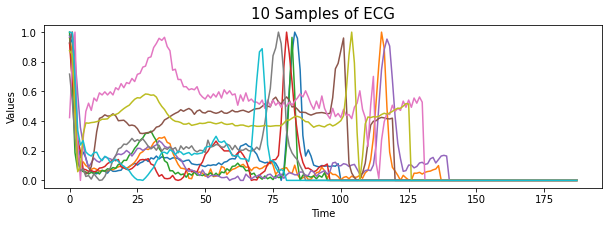

In [4]:
plt.figure(figsize=(10,3))
plt.plot(df_train.iloc[:10, :].T)
plt.title("10 Samples of ECG", fontsize=15)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [6]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.Tensor(data)
        self.used_cols = [x for x in range(data.shape[1]-1)] # X = except target column
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index, self.used_cols].unsqueeze(1).T
        return x

    def __len__(self):
        return len(self.data) 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
num_class = 5
device = 'cuda'
num_epoch = 200
lr = 1e-4

In [8]:
print(len(df_train), len(df_test))

87554 21892


In [9]:
from sklearn.model_selection import train_test_split

train_dataset = MyDataset(df_train.values)

x_valid, x_test, y_valid, y_test = train_test_split(df_test.iloc[:,:-1],df_test.iloc[:,-1], test_size=0.5, shuffle=True, stratify=df_test.iloc[:,-1], random_state=SEED)
df_valid = pd.DataFrame(x_valid)
df_valid.insert(len(df_valid.columns), "target", pd.Series(y_valid))

df_test = pd.DataFrame(x_test)
df_test.insert(len(df_test.columns), "target", pd.Series(y_test))

valid_dataset = MyDataset(df_valid.values)
test_dataset = MyDataset(df_test.values)

In [10]:
### train / valid / test data length ###
print(len(df_train), len(df_valid), len(df_test))

87554 10946 10946


In [11]:
### train label counts ###
df_train.iloc[:, -1].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [12]:
### valid label counts ###
df_valid.iloc[:, -1].value_counts()

0.0    9059
4.0     804
2.0     724
1.0     278
3.0      81
Name: target, dtype: int64

In [13]:
### test label counts ###
df_test.iloc[:, -1].value_counts()

0.0    9059
4.0     804
2.0     724
1.0     278
3.0      81
Name: target, dtype: int64

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [34]:
result_folder = '../check/cnn/reconstruction/'
os.makedirs(result_folder, exist_ok=True)

attack_result_folder = '../check/cnn/reconstruction_attack/'
os.makedirs(attack_result_folder, exist_ok=True)

In [16]:
class CNN(nn.Module):
    def __init__(self, in_features, out_features, pool_size, hidden_dim, capsule_num):
        super().__init__()
        self.output = out_features
        self.pool_size = pool_size
        
        self.hidden_dim = hidden_dim
        self.capsule_num = capsule_num
        
        self.conv1 = nn.Conv2d(in_features, self.hidden_dim, kernel_size=(1, 9), stride=1)
        self.pool1 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv2 = nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=(1, 9), stride=(1,2))
        self.pool2 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv3 = nn.Conv2d(self.hidden_dim, 5*16, kernel_size=(1,1), stride=1)
        self.pool3 = nn.AdaptiveMaxPool2d(1)
       
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(5*16, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.out = nn.Linear(1024, out_features)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x.unsqueeze(2))))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        
        x = self.flatten(x).unsqueeze(1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.out(x))
        
        return x

In [17]:
model = CNN(in_features= 1,
            out_features=len(df_train.columns)-1, #classifcation = 5
            pool_size=2, hidden_dim = 256, capsule_num=8).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [18]:
model

CNN(
  (conv1): Conv2d(1, 256, kernel_size=(1, 9), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 256, kernel_size=(1, 9), stride=(1, 2))
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 80, kernel_size=(1, 1), stride=(1, 1))
  (pool3): AdaptiveMaxPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=80, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=187, bias=True)
)

# 3. Model Training & Evaluation #

In [20]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x) in tqdm(train_loader, leave=False):
        x = x.to(device)

        optimizer.zero_grad()
        outputs = model(x)

        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            
            answers.extend(x.squeeze().detach().cpu().numpy())

            outputs = model(x)
            loss = criterion(outputs, x)
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    """
    if epoch % 20 ==0 :
        torch.save({
            'epoch': epoch,
            'loss' :, valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, f'./check/cnn/recon/cnn-swcapsule-recon-ecg-{epoch}.pt')
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss' : valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-recon-ecg-best.pt')

  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 0/200 | trn_loss: 0.0184 | val_loss: 0.0141


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 1/200 | trn_loss: 0.0130 | val_loss: 0.0125


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 2/200 | trn_loss: 0.0117 | val_loss: 0.0113


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 3/200 | trn_loss: 0.0111 | val_loss: 0.0111


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 4/200 | trn_loss: 0.0106 | val_loss: 0.0104


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 5/200 | trn_loss: 0.0103 | val_loss: 0.0102


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 6/200 | trn_loss: 0.0101 | val_loss: 0.0101


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 7/200 | trn_loss: 0.0099 | val_loss: 0.0100


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 8/200 | trn_loss: 0.0097 | val_loss: 0.0098


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 9/200 | trn_loss: 0.0095 | val_loss: 0.0097


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 10/200 | trn_loss: 0.0094 | val_loss: 0.0106


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 11/200 | trn_loss: 0.0093 | val_loss: 0.0097


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 12/200 | trn_loss: 0.0091 | val_loss: 0.0091


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 13/200 | trn_loss: 0.0090 | val_loss: 0.0092


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 14/200 | trn_loss: 0.0089 | val_loss: 0.0092


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 15/200 | trn_loss: 0.0088 | val_loss: 0.0090


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 16/200 | trn_loss: 0.0087 | val_loss: 0.0090


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 17/200 | trn_loss: 0.0086 | val_loss: 0.0089


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 18/200 | trn_loss: 0.0086 | val_loss: 0.0088


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 19/200 | trn_loss: 0.0085 | val_loss: 0.0087


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 20/200 | trn_loss: 0.0084 | val_loss: 0.0087


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 21/200 | trn_loss: 0.0083 | val_loss: 0.0085


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 22/200 | trn_loss: 0.0083 | val_loss: 0.0086


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 23/200 | trn_loss: 0.0082 | val_loss: 0.0086


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 24/200 | trn_loss: 0.0081 | val_loss: 0.0084


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 25/200 | trn_loss: 0.0081 | val_loss: 0.0083


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 26/200 | trn_loss: 0.0080 | val_loss: 0.0083


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 27/200 | trn_loss: 0.0080 | val_loss: 0.0083


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 28/200 | trn_loss: 0.0079 | val_loss: 0.0084


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 29/200 | trn_loss: 0.0079 | val_loss: 0.0081


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 30/200 | trn_loss: 0.0078 | val_loss: 0.0082


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 31/200 | trn_loss: 0.0078 | val_loss: 0.0081


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 32/200 | trn_loss: 0.0077 | val_loss: 0.0082


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 33/200 | trn_loss: 0.0077 | val_loss: 0.0081


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 34/200 | trn_loss: 0.0076 | val_loss: 0.0080


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 35/200 | trn_loss: 0.0076 | val_loss: 0.0079


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 36/200 | trn_loss: 0.0075 | val_loss: 0.0088


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 37/200 | trn_loss: 0.0075 | val_loss: 0.0079


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 38/200 | trn_loss: 0.0075 | val_loss: 0.0079


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 39/200 | trn_loss: 0.0074 | val_loss: 0.0078


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 40/200 | trn_loss: 0.0074 | val_loss: 0.0078


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 41/200 | trn_loss: 0.0074 | val_loss: 0.0079


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 42/200 | trn_loss: 0.0073 | val_loss: 0.0079


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 43/200 | trn_loss: 0.0073 | val_loss: 0.0078


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 44/200 | trn_loss: 0.0072 | val_loss: 0.0078


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 45/200 | trn_loss: 0.0072 | val_loss: 0.0079


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 46/200 | trn_loss: 0.0072 | val_loss: 0.0080


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 47/200 | trn_loss: 0.0072 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 48/200 | trn_loss: 0.0071 | val_loss: 0.0077


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 49/200 | trn_loss: 0.0071 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 50/200 | trn_loss: 0.0071 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 51/200 | trn_loss: 0.0070 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 52/200 | trn_loss: 0.0070 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 53/200 | trn_loss: 0.0070 | val_loss: 0.0078


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 54/200 | trn_loss: 0.0070 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 55/200 | trn_loss: 0.0069 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 56/200 | trn_loss: 0.0069 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 57/200 | trn_loss: 0.0069 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 58/200 | trn_loss: 0.0068 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 59/200 | trn_loss: 0.0068 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 60/200 | trn_loss: 0.0068 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 61/200 | trn_loss: 0.0068 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 62/200 | trn_loss: 0.0068 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 63/200 | trn_loss: 0.0067 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 64/200 | trn_loss: 0.0067 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 65/200 | trn_loss: 0.0067 | val_loss: 0.0078


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 66/200 | trn_loss: 0.0067 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 67/200 | trn_loss: 0.0066 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 68/200 | trn_loss: 0.0066 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 69/200 | trn_loss: 0.0066 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 70/200 | trn_loss: 0.0066 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 71/200 | trn_loss: 0.0066 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 72/200 | trn_loss: 0.0065 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 73/200 | trn_loss: 0.0065 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 74/200 | trn_loss: 0.0065 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 75/200 | trn_loss: 0.0065 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 76/200 | trn_loss: 0.0064 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 77/200 | trn_loss: 0.0064 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 78/200 | trn_loss: 0.0064 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 79/200 | trn_loss: 0.0064 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 80/200 | trn_loss: 0.0064 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 81/200 | trn_loss: 0.0064 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 82/200 | trn_loss: 0.0063 | val_loss: 0.0076


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 83/200 | trn_loss: 0.0063 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 84/200 | trn_loss: 0.0063 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 85/200 | trn_loss: 0.0063 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 86/200 | trn_loss: 0.0063 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 87/200 | trn_loss: 0.0063 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 88/200 | trn_loss: 0.0062 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 89/200 | trn_loss: 0.0062 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 90/200 | trn_loss: 0.0062 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 91/200 | trn_loss: 0.0062 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 92/200 | trn_loss: 0.0062 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 93/200 | trn_loss: 0.0062 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 94/200 | trn_loss: 0.0061 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 95/200 | trn_loss: 0.0061 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 96/200 | trn_loss: 0.0061 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 97/200 | trn_loss: 0.0061 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 98/200 | trn_loss: 0.0061 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 99/200 | trn_loss: 0.0061 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 100/200 | trn_loss: 0.0060 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 101/200 | trn_loss: 0.0060 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 102/200 | trn_loss: 0.0060 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 103/200 | trn_loss: 0.0060 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 104/200 | trn_loss: 0.0060 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 105/200 | trn_loss: 0.0060 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 106/200 | trn_loss: 0.0060 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 107/200 | trn_loss: 0.0060 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 108/200 | trn_loss: 0.0059 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 109/200 | trn_loss: 0.0059 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 110/200 | trn_loss: 0.0059 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 111/200 | trn_loss: 0.0059 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 112/200 | trn_loss: 0.0059 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 113/200 | trn_loss: 0.0059 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 114/200 | trn_loss: 0.0059 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 115/200 | trn_loss: 0.0058 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 116/200 | trn_loss: 0.0058 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 117/200 | trn_loss: 0.0058 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 118/200 | trn_loss: 0.0058 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 119/200 | trn_loss: 0.0058 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 120/200 | trn_loss: 0.0058 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 121/200 | trn_loss: 0.0058 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 122/200 | trn_loss: 0.0057 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 123/200 | trn_loss: 0.0057 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 124/200 | trn_loss: 0.0057 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 125/200 | trn_loss: 0.0057 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 126/200 | trn_loss: 0.0057 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 127/200 | trn_loss: 0.0057 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 128/200 | trn_loss: 0.0057 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 129/200 | trn_loss: 0.0057 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 130/200 | trn_loss: 0.0056 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 131/200 | trn_loss: 0.0056 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 132/200 | trn_loss: 0.0056 | val_loss: 0.0074


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 133/200 | trn_loss: 0.0056 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 134/200 | trn_loss: 0.0056 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 135/200 | trn_loss: 0.0056 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 136/200 | trn_loss: 0.0056 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 137/200 | trn_loss: 0.0056 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 138/200 | trn_loss: 0.0056 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 139/200 | trn_loss: 0.0056 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 140/200 | trn_loss: 0.0056 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 141/200 | trn_loss: 0.0055 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 142/200 | trn_loss: 0.0055 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 143/200 | trn_loss: 0.0055 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 144/200 | trn_loss: 0.0055 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 145/200 | trn_loss: 0.0055 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 146/200 | trn_loss: 0.0055 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 147/200 | trn_loss: 0.0055 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 148/200 | trn_loss: 0.0055 | val_loss: 0.0075


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 149/200 | trn_loss: 0.0055 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 150/200 | trn_loss: 0.0054 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 151/200 | trn_loss: 0.0054 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 152/200 | trn_loss: 0.0054 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 153/200 | trn_loss: 0.0054 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 154/200 | trn_loss: 0.0054 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 155/200 | trn_loss: 0.0054 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 156/200 | trn_loss: 0.0054 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 157/200 | trn_loss: 0.0054 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 158/200 | trn_loss: 0.0054 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 159/200 | trn_loss: 0.0053 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 160/200 | trn_loss: 0.0053 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 161/200 | trn_loss: 0.0053 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 162/200 | trn_loss: 0.0053 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 163/200 | trn_loss: 0.0053 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 164/200 | trn_loss: 0.0053 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 165/200 | trn_loss: 0.0053 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 166/200 | trn_loss: 0.0053 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 167/200 | trn_loss: 0.0053 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 168/200 | trn_loss: 0.0053 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 169/200 | trn_loss: 0.0053 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 170/200 | trn_loss: 0.0053 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 171/200 | trn_loss: 0.0052 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 172/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 173/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 174/200 | trn_loss: 0.0052 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 175/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 176/200 | trn_loss: 0.0052 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 177/200 | trn_loss: 0.0052 | val_loss: 0.0070


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 178/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 179/200 | trn_loss: 0.0052 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 180/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 181/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 182/200 | trn_loss: 0.0052 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 183/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 184/200 | trn_loss: 0.0051 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 185/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 186/200 | trn_loss: 0.0051 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 187/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 188/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 189/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 190/200 | trn_loss: 0.0051 | val_loss: 0.0073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 191/200 | trn_loss: 0.0051 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 192/200 | trn_loss: 0.0051 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 193/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 194/200 | trn_loss: 0.0051 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 195/200 | trn_loss: 0.0051 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 196/200 | trn_loss: 0.0050 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 197/200 | trn_loss: 0.0050 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 198/200 | trn_loss: 0.0050 | val_loss: 0.0071


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 199/200 | trn_loss: 0.0050 | val_loss: 0.0072


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 200/200 | trn_loss: 0.0050 | val_loss: 0.0071


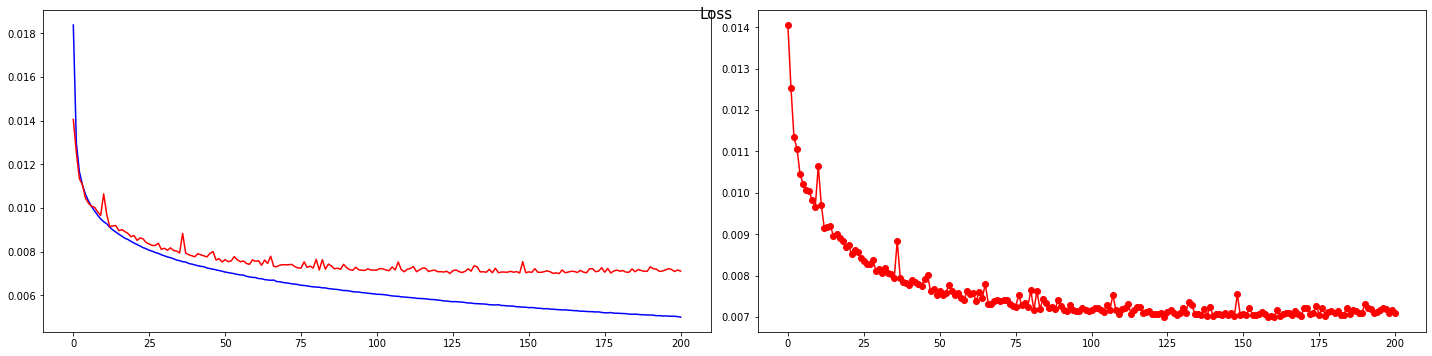

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'drcnn_loss.png')

In [ ]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'drcnn_loss.csv', index=0)

### Performance Evaluation

In [35]:
checkpoint = torch.load(result_folder+'cnn-swcapsule-recon-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

160 0.006992920716076569


In [36]:
model = model.eval()
test_loss = []
answers = []
predictions = []
with torch.no_grad():
    for (x) in tqdm(test_loader, leave=False):
        x = x.to(device)
        answers.extend(x.squeeze().detach().cpu().numpy())

        outputs = model(x)
        loss = criterion(outputs, x) 
            
        predictions.extend(outputs.squeeze().detach().cpu().numpy())  
        test_loss.append(loss.item())
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

  0%|          | 0/172 [00:00<?, ?it/s]

test loss: 0.006964888301851271


In [37]:
result_ans = pd.DataFrame(answers)
result_ans.to_csv(result_folder + 'recon_result.csv')

result_pred = pd.DataFrame(predictions)
result_pred.to_csv(result_folder + 'recon_pred.csv')

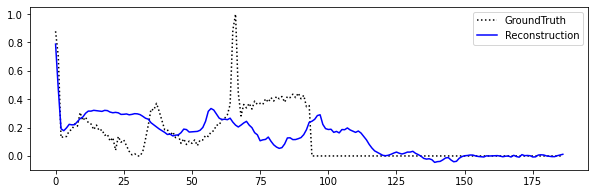

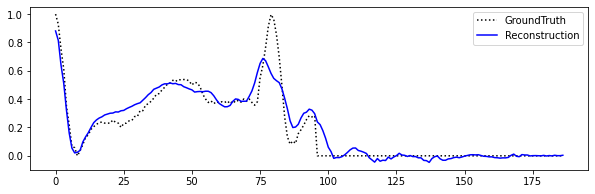

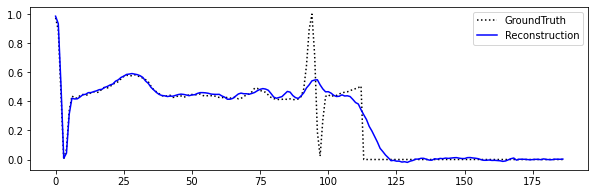

In [38]:
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i, :], c='blue', label='Reconstruction')
    plt.legend()
    plt.savefig(result_folder + f'sample{i}_reconresult.png')

## Manual Attack

In [39]:
checkpoint = torch.load(result_folder+'cnn-swcapsule-recon-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

160 0.006992920716076569


In [40]:
import copy
def offset(input_, offset=0.1, window=35, num_sample=1,
           random_noise=True, max_rand_noise=0.01, label_last_col=False, 
           multi_var=0):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    offset: constant value in the range of 0-1, which will be plus added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert offset >= 0 and offset <= 1, "Incorrect range of offset value"
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]

    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)    
    
    if multi_var != 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += offset + noise[j,:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i,start_idx:end_idx] += offset + noise[j,:]
            
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
    
        return x, indices
    
    
def drift(input_, scale=0.1, window=35, num_sample=1, type_='increasing', 
          random_noise=True, max_rand_noise=0.01, label_last_col=False,
          multi_var=0):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    scale: constant value in the range of 0-1, which will be plus increasingly added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    type: options consists of 'increasing' and 'decreasing'
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert scale >= 0 and scale <= 1, "Incorrect range of scale value"
    
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    if len(x.shape)<3:
        start_idx = np.random.randint(0, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)

    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += f + noise[j,:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i, start_idx:end_idx] += f + noise[j,:]
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices
    

def lagging(input_, lag_time=15, num_sample=1, multi_var=0, type_='backward',
            random_noise=True, max_rand_noise=0.01, label_last_col=False):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...).
    lag_time: integer which is lagging duration.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start]
    """
    x = copy.deepcopy(input_)
    assert lag_time >= 0, "Incorrect range of lag time"
#     assert type(lag_time) is int, "Incorrect data type of lag time"
    if label_last_col==True:
        if len(x.shape)>2: # multivariate
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else: #univariate
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    
    idxs = range(num_sample)
    if type_=='backward':
        start_idx = np.random.randint(lag_time, x.shape[1]-2*lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    else: # 'forward'
        start_idx = np.random.randint(2*lag_time, x.shape[1]-lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx), axis=1)            
    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx:x.shape[1],sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:start_idx,sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += noise[:,p]
            else: # 'forward'
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx] = x[i,start_idx:x.shape[1],sensor_idx]
                    x[i,x.shape[1]-lag_time:x.shape[1],sensor_idx] = x[i,x.shape[1]-lag_time,sensor_idx]
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += noise[:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx-lag_time:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx-lag_tim:x.shape[1]].shape[0]))
                x.iloc[i,start_idx-lag_time:x.shape[1]] = x.iloc[i,start_idx-lag_time:x.shape[1]].shift(periods=lag_time, fill_value=x.iloc[i,start_idx-lag_time])
                x.iloc[i,start_idx-lag_time:x.shape[1]] += noise
            else:
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                x.iloc[i,start_idx:x.shape[1]] = x.iloc[i,start_idx:x.shape[1]].shift(periods=-lag_time-1, fill_value=0)
                x.iloc[i,start_idx:x.shape[1]] += noise     
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices

In [41]:
offsets, offset_idx = offset(df_test, offset=0.1, window=55, num_sample=df_test.shape[0], 
                             max_rand_noise=0.01, label_last_col=True)
increasing, increase_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='increasing',
                            max_rand_noise=0.01, label_last_col=True)
decreasing, decrease_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='decreasing',
                            max_rand_noise=0.01, label_last_col=True)
backward, backward_idx = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="backward", 
                            max_rand_noise=0.01, label_last_col=True)
forward, forward_idx   = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="forward", 
                            max_rand_noise=0.01, label_last_col=True)

offset_test_dataset = MyDataset(offsets.values)
offset_test_loader = torch.utils.data.DataLoader(offset_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

increasing_test_dataset = MyDataset(increasing.values)
increasing_test_loader = torch.utils.data.DataLoader(increasing_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

decreasing_test_dataset = MyDataset(decreasing.values)
decreasing_test_loader = torch.utils.data.DataLoader(decreasing_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

backward_test_dataset = MyDataset(backward.values)
backward_test_loader = torch.utils.data.DataLoader(backward_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

forward_test_dataset = MyDataset(forward.values)
forward_test_loader = torch.utils.data.DataLoader(forward_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

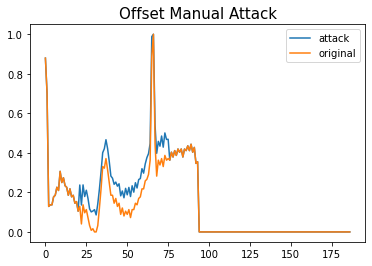

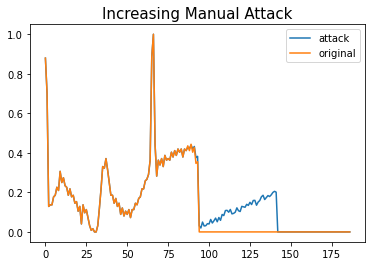

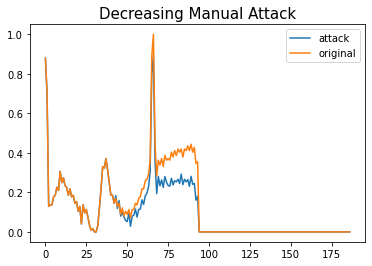

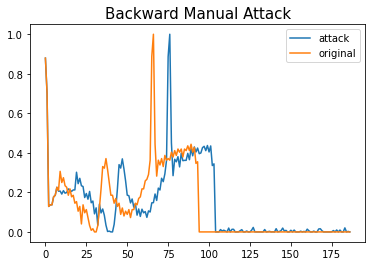

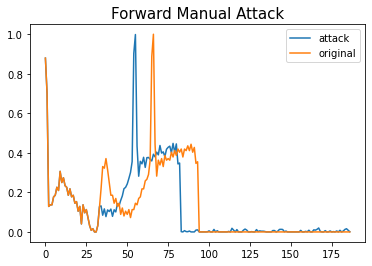

In [42]:
plt.plot(offsets.iloc[offset_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[offset_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Offset Manual Attack", fontsize=15)
plt.show()
plt.plot(increasing.iloc[increase_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[increase_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Increasing Manual Attack", fontsize=15)
plt.show()
plt.plot(decreasing.iloc[decrease_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[decrease_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Decreasing Manual Attack", fontsize=15)
plt.show()
plt.plot(backward.iloc[backward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[backward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Backward Manual Attack", fontsize=15)
plt.show()
plt.plot(forward.iloc[forward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[forward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Forward Manual Attack", fontsize=15)
plt.show()

In [43]:
def attack_inference(model, test_loader, attack):
    model = model.eval()
    test_loss = []
    predictions = []
    answers = []
    with torch.no_grad():
        for (x) in tqdm(test_loader, leave=False):
            x = x.to(device)

            answers.extend(x.squeeze().detach().cpu().numpy())

            outputs = model(x).squeeze()
            loss = criterion(outputs, x) 

            predictions.extend(outputs.squeeze().detach().cpu().numpy())  

            test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    return answers, predictions

In [44]:
def np_mse(A, B):
    return (np.square(A - B)).mean()

  0%|          | 0/172 [00:00<?, ?it/s]

offset 0.02034007


  0%|          | 0/172 [00:00<?, ?it/s]

increasing 0.015579322


  0%|          | 0/172 [00:00<?, ?it/s]

decreasing 0.011494178


  0%|          | 0/172 [00:00<?, ?it/s]

backward 0.014575084


  0%|          | 0/172 [00:00<?, ?it/s]

forward 0.011855214


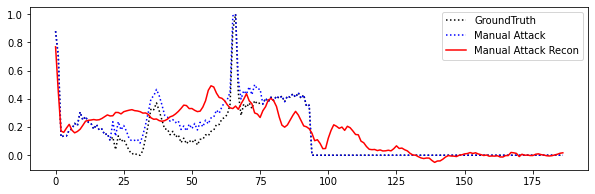

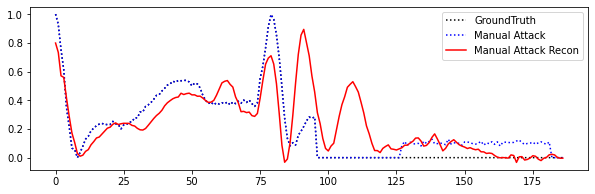

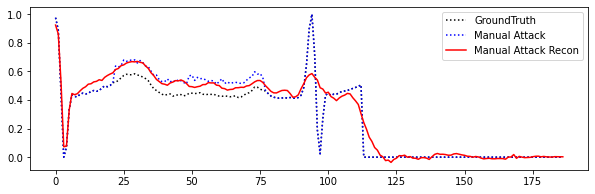

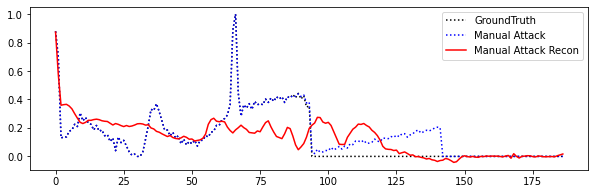

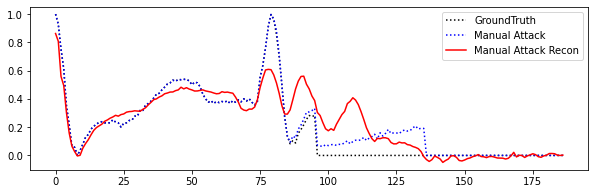

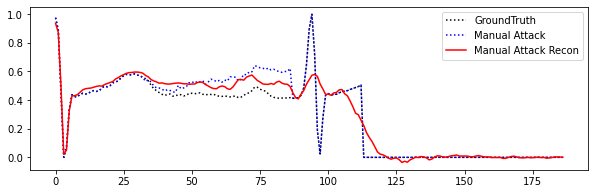

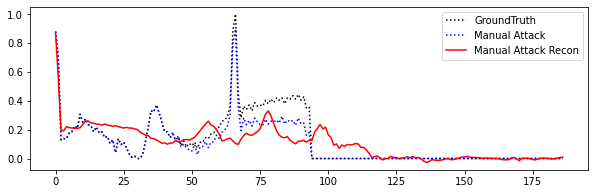

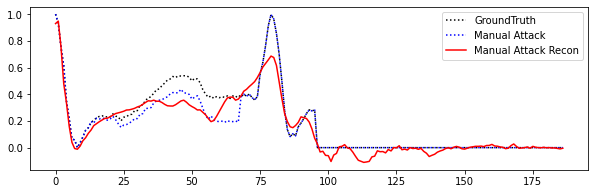

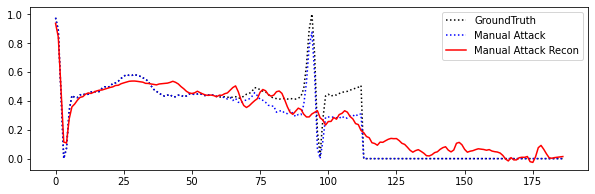

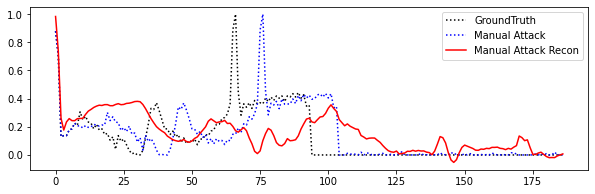

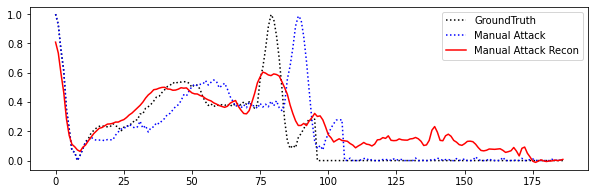

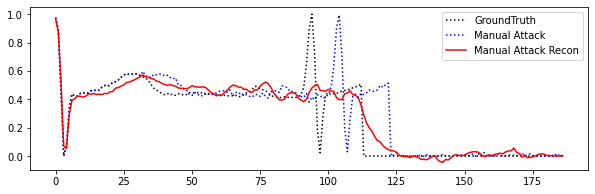

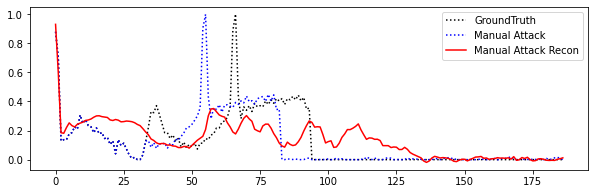

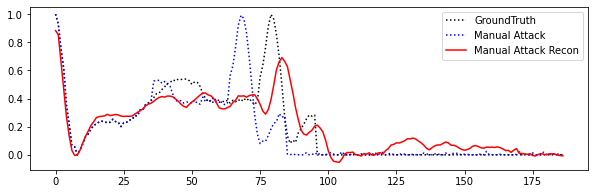

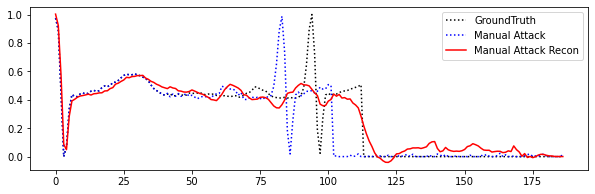

In [45]:
for attack in ['offset', 'increasing', 'decreasing', 'backward', 'forward']:
    if attack == 'offset':
        attack_loader = offset_test_loader 
    if attack == 'increasing':
        attack_loader = increasing_test_loader 
    if attack == 'decreasing':
        attack_loader = decreasing_test_loader 
    if attack == 'backward':
        attack_loader = backward_test_loader 
    if attack == 'forward':
        attack_loader = forward_test_loader 
        
    answers, predictions = attack_inference(model,attack_loader, attack)
    print(attack, np_mse(result_ans.values, predictions))
    result_ans_attack = pd.DataFrame(answers)
    result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_reconstruction.csv')
    result_pred_attack = pd.DataFrame(predictions)
    result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_reconstruction_pred.csv')
    
    for i in range(3):
        plt.figure(figsize=(10,3))
        plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
        plt.plot(result_ans_attack.iloc[i, :], c='blue', ls=':', label='Manual Attack')
        plt.plot(result_pred_attack.iloc[i, :], c='red', label='Manual Attack Recon')
        plt.legend()
        plt.savefig(result_folder + f'{attack}_sample{i}_reconresult.png')

## Balck Box Attack - fgsm

In [46]:
fgsm_attack = pd.read_csv(data_folder +'ECG_adv-eps-0.1-test.csv')
fgsm_attack = fgsm_attack.loc[df_test.index]
len(fgsm_attack)

10946

In [47]:
fgsm_test_dataset = MyDataset(fgsm_attack.values)
fgsm_test_loader = torch.utils.data.DataLoader(fgsm_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

  0%|          | 0/172 [00:00<?, ?it/s]

fgsm 0.05975179


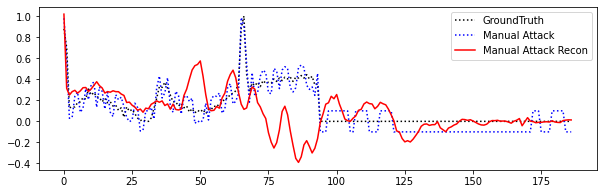

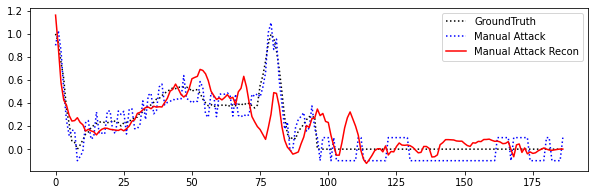

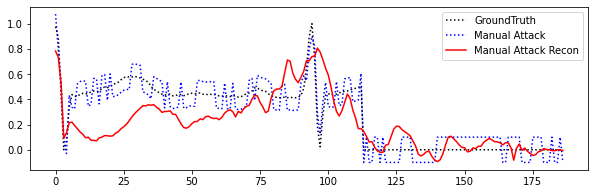

In [48]:
attack = 'fgsm'
answers, predictions = attack_inference(model,fgsm_test_loader, attack)
print(attack, np_mse(result_ans.values, predictions))
result_ans_attack = pd.DataFrame(answers)
result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_reconstruction.csv')
result_pred_attack = pd.DataFrame(predictions)
result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_reconstruction_pred.csv')
    
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_ans_attack.iloc[i, :], c='blue', ls=':', label='Manual Attack')
    plt.plot(result_pred_attack.iloc[i, :], c='red', label='Manual Attack Recon')
    plt.legend()
    plt.savefig(result_folder + f'{attack}_sample{i}_reconresult.png')